In [29]:
# Imports
import pandas as pd
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
import json
import os
import openpyxl

import warnings
warnings.filterwarnings("ignore")


# Data loader and analiser class

In [80]:
class Love_Hate_LNU_analiser:
    def __init__(self, data_path: str, data_sheet_in: str, data_sheet_out: str = ''):
        self.data_path = data_path
        self.data_sheet = data_sheet_in

        # Autmatically load the given data
        self.data_transfers_in = self.load_reference(data_path, data_sheet_in)
        self.data_transfers_out = self.load_reference(data_path, data_sheet_out)

    def load_reference(self, data_path: str, data_sheet: str):
        df = pd.read_excel(data_path, sheet_name=data_sheet)
        df = self.reformat_input_data(df)
        return df

    def reformat_input_data(self, df: pd.DataFrame):
        if 'payment_wallet' in df.keys():
            # incoming payments
            df['payment_wallet'] = df['payment_wallet'].fillna(method='bfill')
        df['from_address'] = df['from_address'].astype(str).str.lower()
        df['to_address'] = df['to_address'].astype(str).str.lower()
        df['value_in_usd'] = df['value_in_usd'].astype(float)
        
        return df


    def make_all_plots(self):
        # self.all_transaction_values(self.data_transfers_in, self.data_transfers_out)
        # self.common_buyers(self.data_transfers_in, bins = 50)
        # self.most_amount_buyers(self.data_transfers_in, bins = 50)

        self.wallet_transfer_amount_and_count(self.data_transfers_out, self.data_transfers_in)

    def all_transaction_values(self, data_transfers_in, data_transfers_out):
        #Logaritmus miatt meg kell szűrni az adatokat
        filtered_in_transfers  = data_transfers_in[data_transfers_in['value_in_usd'] > 0]['value_in_usd']
        filtered_out_transfers = data_transfers_out[data_transfers_out['value_in_usd'] > 0]['value_in_usd']

        # Making the plot
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

        axes[0].hist(np.log10(filtered_in_transfers), bins=50, color='skyblue', edgecolor='black')
        axes[0].set_title('Distribution of Transaction Values (Presale buy)')
        axes[0].set_xlabel('Transaction Value (USD)')
        axes[0].set_ylabel('Frequency')
        axes[0].grid(axis='y', alpha=0.75)

        x_formatter = FuncFormatter(lambda x, pos: '${:,.0f}'.format(10**x))
        axes[0].xaxis.set_major_formatter(x_formatter)

        y_formatter = FuncFormatter(lambda x, pos: '{:,.0f}'.format(x))
        axes[0].yaxis.set_major_formatter(y_formatter)

        ticks = [1, 2, 3, 4, 5, 6]
        axes[0].set_xticks(ticks)

        axes[1].hist(np.log10(filtered_out_transfers), bins=50, color='lightgreen', edgecolor='black')
        axes[1].set_title('Distribution of Transaction Values (Wallet transfers)')
        axes[1].set_xlabel('Transaction Value (USD)')
        axes[1].set_ylabel('Frequency')
        axes[1].grid(axis='y', alpha=0.75)
        axes[1].xaxis.set_major_formatter(x_formatter)
        axes[1].set_xticks(ticks)
        plt.tight_layout()
        plt.savefig('../Presale_plots/eth_all_transaction_values.pdf')
        plt.show()
    
    def plot_distribution(self, unique_addresses, values, ylabel, title, yticks, formatter, filename):
        plt.figure(figsize=(10, 6))
        plt.scatter(unique_addresses, values, color='skyblue', edgecolor='black')
        plt.title(title)
        plt.xlabel('')
        plt.ylabel(ylabel)
        plt.grid(axis='y', alpha=0.75)
        plt.gca().yaxis.set_major_formatter(formatter)
        plt.yticks(yticks)
        plt.xticks([])
        plt.savefig(filename)
        plt.show()

    def common_buyers(self, data_transfers_in, bins=50):
        data_transfers_in['address_pair'] = data_transfers_in.apply(lambda row: tuple(sorted([row['from_address'], row['to_address']])), axis=1)

        transaction_counts = data_transfers_in.groupby('address_pair').size()
        transaction_counts_df = transaction_counts.reset_index(name='transaction_count')

        top_n_transactions = transaction_counts_df.nlargest(bins, 'transaction_count')
        top_n_transactions[['from_address', 'to_address']] = top_n_transactions['address_pair'].apply(pd.Series)
        top_n_transactions.drop('address_pair', axis=1, inplace=True)

        unique_addresses = list(set(top_n_transactions['to_address'].values.tolist() + top_n_transactions['from_address'].values.tolist()))[:-1]

        values = np.log10(top_n_transactions['transaction_count'])
        ylabel = 'Frequency'
        title = 'Distribution of number of transactions per addresses'
        formatter = FuncFormatter(lambda x, pos: '{:,.0f}'.format(10**x))
        yticks = [1, 2, 3, 4]
        filename = '../Presale_plots/eth_top_frequency.pdf'

        self.plot_distribution(unique_addresses, values, ylabel, title, yticks, formatter, filename)

    def most_amount_buyers(self, data_transfers_in, bins=50):
        data_transfers_in['address_pair'] = data_transfers_in.apply(lambda row: tuple(sorted([row['from_address'], row['to_address']])), axis=1)
        sum_of_value_of_transactions = data_transfers_in.groupby('address_pair')['value_in_usd'].sum().reset_index()

        top_n_value = sum_of_value_of_transactions.nlargest(bins, 'value_in_usd')
        top_n_value[['from_address', 'to_address']] = top_n_value['address_pair'].apply(pd.Series)
        top_n_value.drop('address_pair', axis=1, inplace=True)

        unique_addresses = list(set(top_n_value['to_address'].values.tolist() + top_n_value['from_address'].values.tolist()))[:-1]

        values = np.log10(top_n_value['value_in_usd'])
        ylabel = 'Value'
        title = 'Distribution of biggest value of transactions per addresses'
        formatter = FuncFormatter(lambda x, pos: '${:,.0f}'.format(10**x))
        yticks = [4, 5, 6]
        filename = '../Presale_plots/eth_top_values.pdf'

        self.plot_distribution(unique_addresses, values, ylabel, title, yticks, formatter, filename)

    def wallet_transfer_amount_and_count(self, data_transfers_out, data_transfers_in):
        
        unique_payment_wallets    = data_transfers_in['payment_wallet'].unique()
        filtered_wallet_transfers = data_transfers_out[data_transfers_out['from_address'].isin(unique_payment_wallets)]

        print(filtered_wallet_transfers)

        #Idő szerint mikor mentek az utalások és mekkora összeggel
        transfer_summary = filtered_wallet_transfers.groupby(['from_address', 'to_address']).agg({'value_in_usd': ['count', 'sum'],
                                                                                                    'timestamp': ['min', 'max']}).reset_index()

        transfer_summary.columns = ['From Address', 'To Address', 'Transaction Count', 'Total Value USD', 'Earliest Transaction', 'Latest Transaction']

        transfer_summary['Earliest Transaction'] = pd.to_datetime(transfer_summary['Earliest Transaction'], unit = 's')
        transfer_summary['Latest Transaction']   = pd.to_datetime(transfer_summary['Latest Transaction'], unit = 's')

        unique_addresses = list(set(transfer_summary['From Address'].values.tolist() + transfer_summary['To Address'].values.tolist()))[:-1]

        #Létrehozni a plotot
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

        #Elnevezzük csak a dolgokat + itt csinálunk log-os átalakítást
        transfer_summary.sort_values('Total Value USD', inplace = True, axis = 0, ascending = False)
        axes[0].scatter(unique_addresses, np.log10(transfer_summary['Total Value USD']), color='skyblue', edgecolor='black')
        axes[0].set_title('Distribution of biggest value of transactions per addresses (Wallet transfers)')
        axes[0].set_xlabel('')
        axes[0].set_ylabel('Value')
        axes[0].grid(axis='y', alpha=0.75)

        formatter = FuncFormatter(lambda x, pos: '${:,.0f}'.format(10**x))
        axes[0].yaxis.set_major_formatter(formatter)

        #X tengelyt még át kell alakítani, a ticks adja meg, hogy a 10 a hányadikonok legyenek a tengelyen
        ticks = [2, 3, 4, 5, 6, 7]
        axes[0].set_yticks(ticks)
        axes[0].set_xticks('')

        #Teljesen ugyanaz mint előbb
        transfer_summary.sort_values('Transaction Count', inplace = True, axis = 0, ascending = False)
        axes[1].scatter(unique_addresses, transfer_summary['Transaction Count'], color='skyblue', edgecolor='black')
        axes[1].set_title('Distribution of number of transactions per addresses (Wallet transfers)')
        axes[1].set_xlabel('')
        axes[1].set_ylabel('Frequency')
        axes[1].grid(axis='y', alpha=0.75)
        axes[1].set_xticks('')

        #Ábrázolás
        plt.tight_layout()
        plt.savefig('../Presale_plots/wallet_transfers_stats.pdf')
        plt.show()



# Using the class to make the plots

Reformatting
  network  value_in_usd     timestamp            datetime_utc  \
0     BSC  2.028093e+05  1.680555e+09 2023-04-03 20:43:55.776   
1     BSC  1.207076e+05  1.681148e+09 2023-04-10 17:31:13.728   
2     BSC  1.069410e+06  1.685689e+09 2023-06-02 06:50:47.328   
3     BSC  4.194319e+05  1.686579e+09 2023-06-12 14:07:22.080   

                                 from_address  \
0  0x99a2770b5c9337f44a00a7677471373c89bf0f36   
1  0x99a2770b5c9337f44a00a7677471373c89bf0f36   
2  0x99a2770b5c9337f44a00a7677471373c89bf0f36   
3  0x99a2770b5c9337f44a00a7677471373c89bf0f36   

                                   to_address  \
0  0x48491f438fcb7b98b97c036627bac7b6af62d5ca   
1  0x48491f438fcb7b98b97c036627bac7b6af62d5ca   
2  0x48491f438fcb7b98b97c036627bac7b6af62d5ca   
3  0xeccf6e64c46c87d422558bdab9bc4051d38f7569   

                                             tx_hash  
0  0x3d567512ad805b6043ab01881fa00701c3532b774ae0...  
1  0xb8efe7d6ddfdfbeb7e4a64218d7e35c5b444263625b1...  
2  0

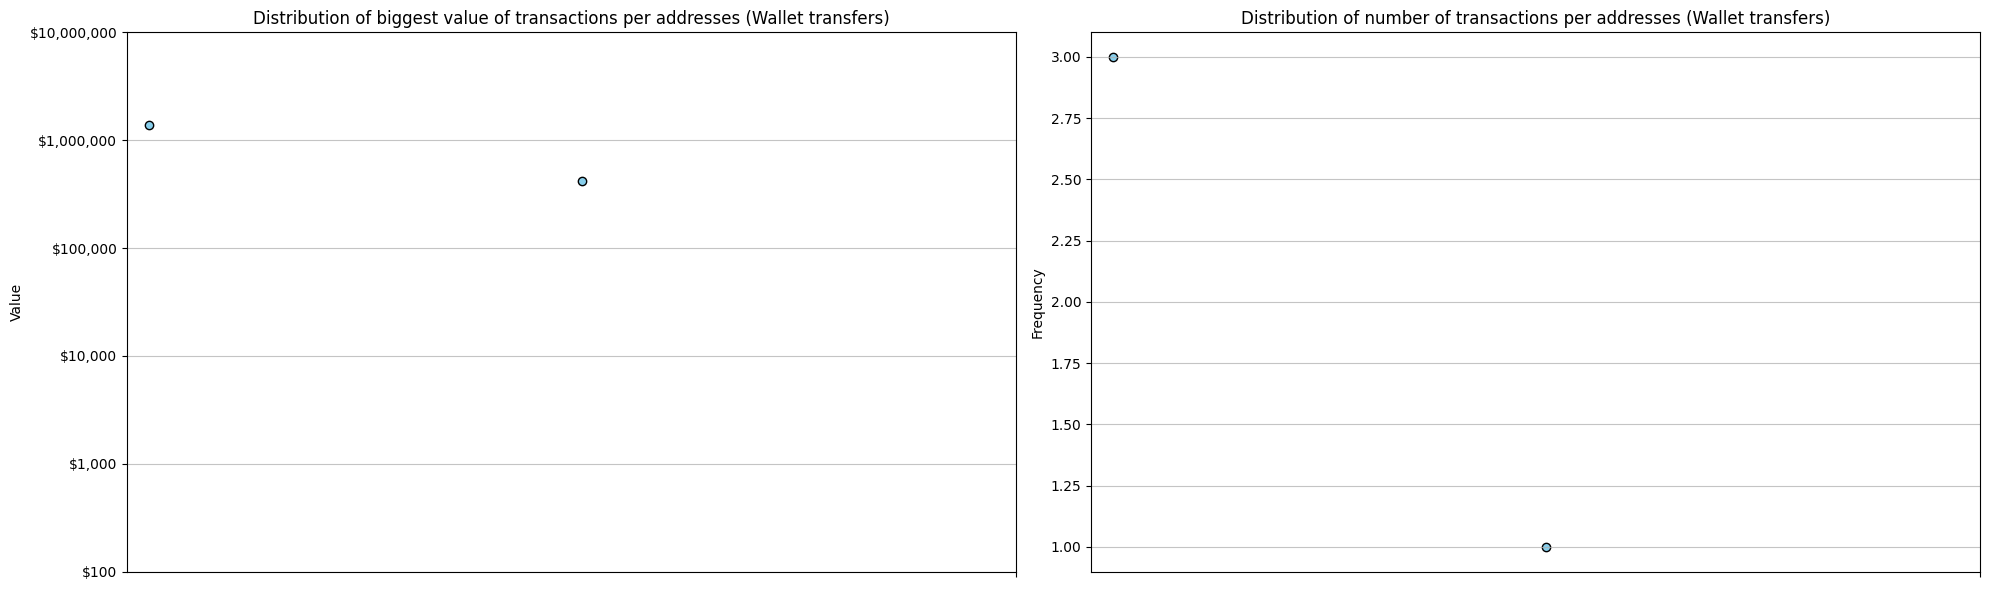

In [81]:
data_path = '../Data/DATA_Love_Hate_Inu_presale.xlsx'
data_sheet_out = 'lhinu_bsc_payment_wallet_transf' # !A1:G6
data_sheet_in = 'lhinu_presale_buy_result_167775'

analiser = Love_Hate_LNU_analiser(data_path=data_path, 
                                  data_sheet_in=data_sheet_in, 
                                  data_sheet_out=data_sheet_out)
analiser.make_all_plots()